# Simulation VAR

But : 
- Implémenter un exemple de série généré par un VAR(1) de faible rang 
- Implémenter une descente de gradient ADMM
- Vérifier l'efficacité de la descente


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import functools, math
import scipy.optimize

/home/CDBDX/remy.garnier/.virtualenvs/prediction/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/CDBDX/remy.garnier/.virtualenvs/prediction/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Génération de la matrice aléatoire

On genère une matrice de $A$  rang $r$ et de taille $n \times n$ . On s'assure que $\|A\|_{S_\infty} = \rho <1$ 

In [3]:
r = 4 #rang de la matrice
n = 30 #taille de la matrice
rho = 0.75

C = 2 * np.random.rand(r,n) - 1
B = 2 * np.random.rand(n,r) - 1
A = B.dot(C)
A = rho * A /np.linalg.norm(A,2)

In [4]:
# Calcul de la SVD, utile pour les décompositions 
u,diagonal, v = np.linalg.svd(A)
u = u[:,:r]

v = np.diag(diagonal) @ v
v = v[:r,:]


### Génération de la série aléatoire

Dans cette parie, on veut générer un série de vecteur $(X_i)$ de taille $m$ de la facon suivante

- $X_0$ est tiré uniformément dans $[0,1]^n$
- $X_{i+1} =  A X_i +\epsilon_t$ ou $(\epsilon_t)$ est un vecteur de bruit gaussien indépendants centrés de variance $\sigma^2$ 

In [5]:
m = 1000
sigma = 1
list_X = list()


X = np.random.rand(n)
list_X.append(X)
for i in range(m):
    X = A.dot(X)  + sigma* np.random.randn(n)
    list_X.append(X)


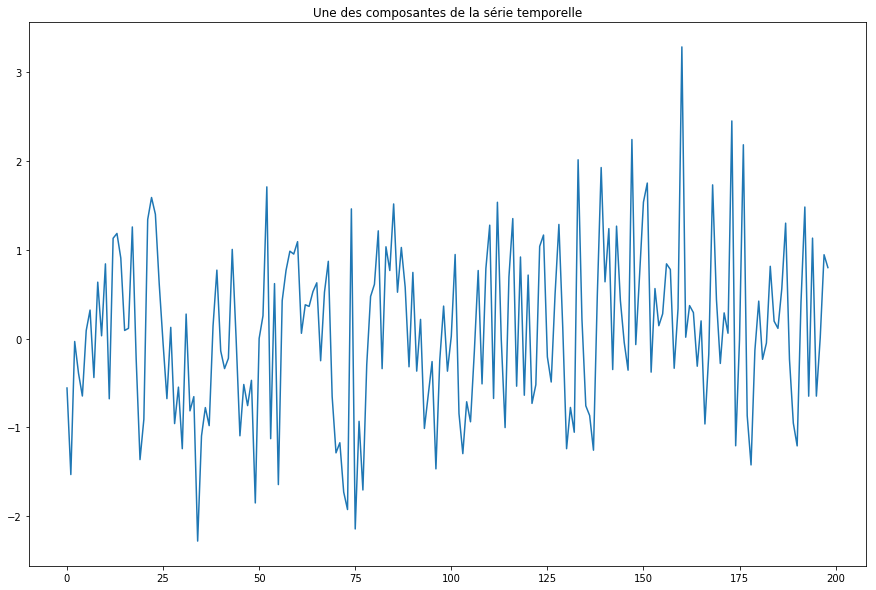

In [6]:
series = [ list_X[i][1] for i in range(m)]

plt.figure(figsize=(15,10))
plt.plot(series[1:200])
plt.title('Une des composantes de la série temporelle')
plt.show()

### Des bouts de codes

Implémentations d'une descente de gradient

In [7]:
def gradient_estimator(function, M, h = 0.0001 ):
    """Estimation simple du gradient
    function: fonction dont on veux estimer le gradient
    M : point ou estimer le gradient
    h : pas d'estimation  
    """
    
    m, n = M.shape
    valeur = function(M)
    gradient = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            Mcopy = M.copy()
            Mcopy[i,j] +=  h 
            valc = function(Mcopy)
            gradient[i,j] = (valc - valeur) / h
    return gradient

def descente_gradient(f, init = A ,alpha_0 = 0.1,  h = 0.0001, nb_iter= 10, init_nul = False, ):
    """Algorithme de descente de gradient avec pas déroissant
    f: fonction à minimiser
    init: point de depart de la minimisation, 0 si init_nul
    nb_iter : nombre d'iteration de descente
    alpha_0 : coefficient initial de minimisation
    """
    m,n = init.shape
    if init_nul:
        act  = np.zeros((m,n))
    else:
        act = init
    for i in range(nb_iter):
        alpha = alpha_0/math.sqrt(i+1)
        act -= alpha * gradient_estimator(f, act, h = h)
    return act

#TODO :ISTA 

In [8]:


def risque_emp(u_tot, v_tot, list_X, penalite = None , coeff_penalisation = 1 ):
    len_list = len(list_X)
    interm = u_tot.dot(v_tot)
    add= 0
    if penalite == 'L1':
        add = np.linalg.norm(interm,1)
    return 1/(len_list-1) * sum( [ np.linalg.norm(list_X[i+1]-interm.dot(list_X[i])) for i in range(len_list-1)]) + coeff_penalisation * add

def partial_u(v_spec, list_X , n = 100, r= 4 , **kwargs):
    def aux(u):
        return risque_emp( v_tot = v_spec, u_tot=u.reshape(n,r) , list_X = list_X , **kwargs)
    return aux

def partial_v(u_spec, list_X,  n = 100, r= 4, **kwargs):
    def aux(v):
        return risque_emp( u_tot = u_spec, v_tot=v.reshape(r,n) , list_X = list_X, **kwargs)
    return aux

def proj(mat, rho ):
    '''Une projection possible sur la boule de norme 1 pour la norme spectrale'''
    if np.linalg.norm(mat, 2) > rho :
        fst,diagonal, thrd = np.linalg.svd(mat, full_matrices=False)
        return fst @ np.diag(np.minimum(diagonal, rho)) @ thrd
    else:
        return mat

In [9]:
#Test des codes précédents:
def f(x):
    return np.linalg.norm(x)


print(risque_emp(u, v,list_X))
print(partial_u(v, list_X, n = n, r=r)(u.reshape(n*r)))

5.458174031856322
5.458174031856322


### Minimisation ADMM

On veut minimiser une fonction de $\mathbb{R}^{n\times r} \times \mathbb{R}^{n\times r} \longrightarrow \mathbb{R}$
$$ f(u,v) = \sum_i \| X_i - u v^T X_{i-1}\|_2 ^2 $$ 
On a choisi la perte quadratique pour obtenir un problème de minimisation bi-convexe
Le but est de minimiser $f$ sachant que $u$ est de norme spectrale inférieure à 1, et $v$ de norme spectrale inférieure à $\rho$.

In [26]:
def admm(list_X, u=u, v=v,  A_init = A ,  epoch = 4, n = 100, r= 4, n_train = 300 , verbose = False, rho = 0.95, u_cur = None, v_cur = None, **kwargs):
    """Minimisation ADMM classique
    list_X : liste des vecteurs observées
    n_train : On garde les n_train premiers vecteurs pour entrainer le modèle(le reste ne sert qu'à l'évaluation)
    r : rang de la matrice recherché
    epoch : nombre de minimisation successive via ADMM
    """
    
    M,K = A_init.shape
    
    list_X_train, list_X_test = list_X[:n_train], list_X[n_train:]
    risk_min_train = risque_emp(u, v,list_X_train)
    risk_min_test = risque_emp(u, v,list_X_test)
    risk_list = list()
    
    
    def get_risk(u,v):
        a,b = (risque_emp(u_cur, v_cur, list_X_test)-risk_min_test) , (risque_emp(u_cur, v_cur, list_X_train)-risk_min_train)
        
        if verbose:
            print("Risque train: %.3f" % b )
            print("Risque test: %.3f" % a )
        return [b,a]   
    
    
    if u_cur is None:
        u_cur = np.random.rand(M,r)
        u_cur = proj(u_cur,1)
    if v_cur is None:
        v_cur = np.random.rand(r,M)
        v_cur = proj(v_cur,rho)
    
    risk_list.append(get_risk(u_cur,v_cur))
    
    for j in range(epoch):
        if verbose:
            print("\nMinimisation " +str(j) )
        fonc = partial_u(v_cur, list_X_train,n=M, r=r , **kwargs)
        #u_cur = descente_gradient( fonc , init= u_cur,alpha_0 = 0.5, init_nul=False)
        
        res = scipy.optimize.minimize(fonc, u_cur.reshape(n*r), method='L-BFGS-B', options={'disp': verbose, 'ftol': 0.001})
        u_cur = res.x.reshape(M,r)
        u_cur = proj(u_cur, 1)
        
        risk_list.append(get_risk(u_cur,v_cur))
        
        fonc = partial_v(u_cur, list_X_train,n=M, r=r , **kwargs)
        #v_cur = descente_gradient( fonc, init= v_cur,alpha_0 = 0.5, init_nul=False)
        res = scipy.optimize.minimize(fonc, v_cur.reshape(n*r), method='L-BFGS-B', options={'disp': verbose, 'ftol': 0.001})
        v_cur = res.x.reshape(r,M)
        v_cur = proj(v_cur, rho)
        
        risk_list.append(get_risk(u_cur,v_cur))
        
    return u_cur, v_cur, risk_list

In [13]:
u_fin, v_fin, risk_list = admm(list_X, r= 4,epoch = 5, verbose=True, rho = 0.75,  n_train = 900, n = n)
#u_L1, v_L1, risk_list_L1 = admm(list_X, r= 4,epoch = 5, verbose=True, rho = 0.75,  n_train = 900, n = n, penalite = 'L1', coeff_penalisation = 0.01)

Risque train: 0.328
Risque test: 0.324

Minimisation 0
Risque train: 0.070
Risque test: 0.107
Risque train: 0.019
Risque test: 0.057

Minimisation 1
Risque train: -0.013
Risque test: 0.051
Risque train: -0.021
Risque test: 0.042

Minimisation 2
Risque train: -0.024
Risque test: 0.041
Risque train: -0.026
Risque test: 0.036

Minimisation 3
Risque train: -0.026
Risque test: 0.035
Risque train: -0.026
Risque test: 0.034

Minimisation 4
Risque train: -0.026
Risque test: 0.034
Risque train: -0.026
Risque test: 0.033


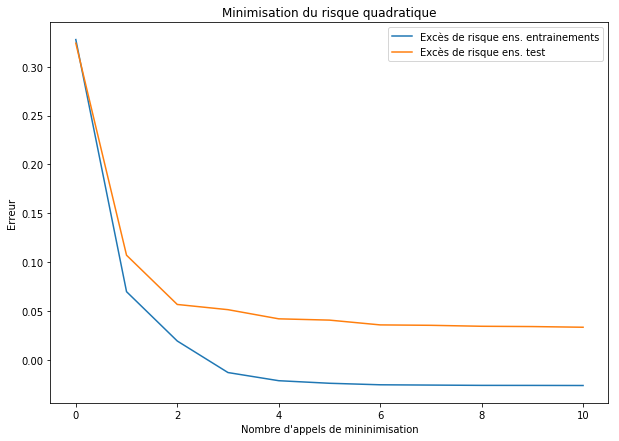

In [14]:
risque_matrice = np.array(risk_list)
#risque_matrice_L1 = np.array(risk_list_L1)
plt.figure(figsize=(10,7))
plt.plot(risque_matrice)
#plt.plot(risque_matrice_L1)
plt.legend(['Excès de risque ens. entrainements','Excès de risque ens. test', 'Excès de risque ens. entrainements L1','Excès de risque ens. test L1'])
plt.title('Minimisation du risque quadratique')
plt.xlabel("Nombre d'appels de mininimisation")
plt.ylabel("Erreur")
plt.show()

### Impact de quelques coefficients

##### Impact du rang:

Regardons ce qui se passe lorsque l'on choisit un rang inférieur au rang de la matrice initiale

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
for i in range(2,5):
    u_fin, v_fin, risk_list = admm(list_X, r= i,epoch = 6, verbose=False, rho = 0.75, n = n, n_train = 900)
    risque_matrice = np.array(risk_list)
    axes[i-2].set_title( "Rang " +str(i))
    axes[i-2].plot(risque_matrice)
    axes[i-2].legend(['Excès de risque ens. entrainements','Excès de risque ens. test'])
    
plt.show()

##### Impact de la dimension sous-jacente

In [23]:
#on reprends les bouts de codes du début

def generation_matrice(r = 4, n = 30, rho = 0.75):
    '''
    r : rang de la matrice
    n : taille de la matrice
    rho : norme spectrale de la matice 
    '''
    C = 2 * np.random.rand(r,n) - 1
    B = 2 * np.random.rand(n,r) - 1
    A = B.dot(C)
    A = rho * A /np.linalg.norm(A,2)
    u,diagonal, v = np.linalg.svd(A)
    u = u[:,:r]

    v = np.diag(diagonal) @ v
    v = v[:r,:]
    return u, v, A

def generation_serie(A, n = 30, m = 1000 , sigma = 1):
    list_X = list()
    X = np.random.rand(n)
    list_X.append(X)
    for i in range(m):
        X = A.dot(X)  + sigma* np.random.randn(n)
        list_X.append(X)
    return list_X



    
    

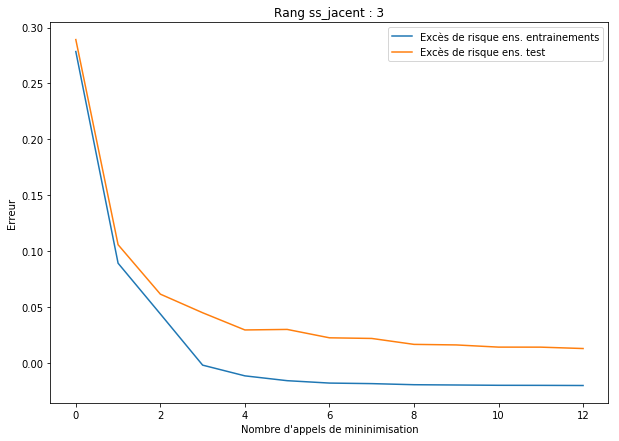

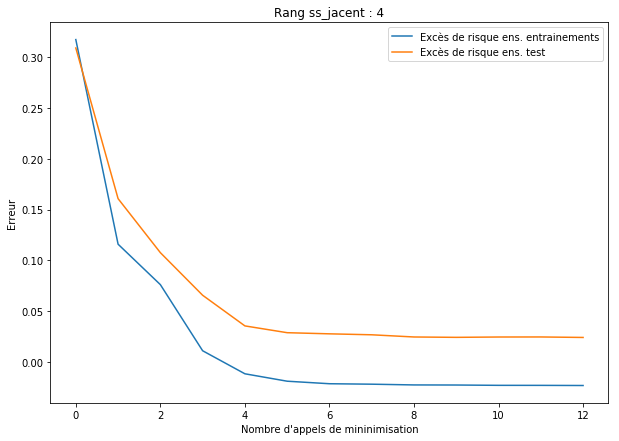

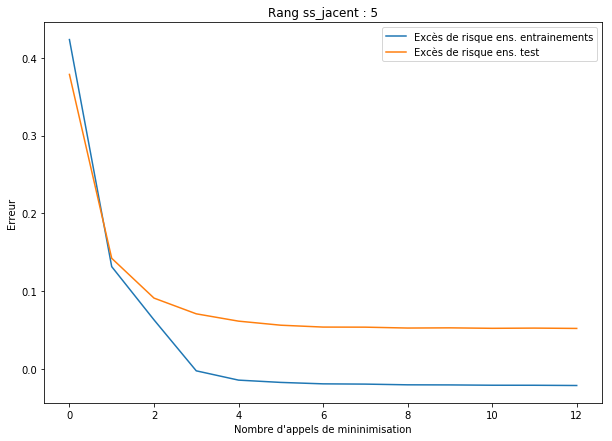

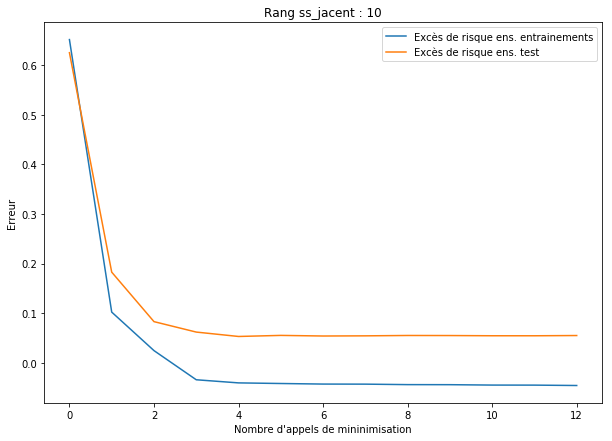

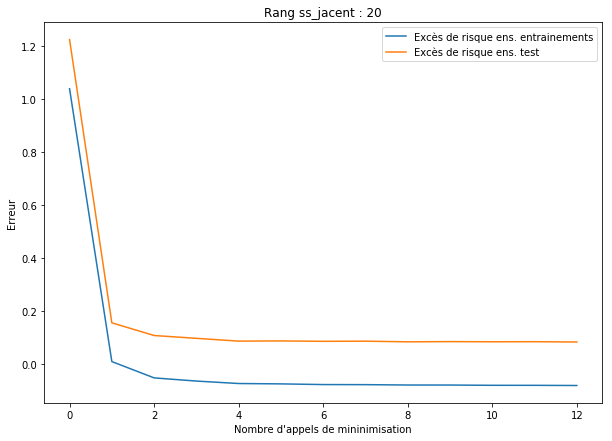

In [33]:
for rang_ss_jacent in [3,4,5,10,20]:
    u, v, A = generation_matrice(r= rang_ss_jacent)
    list_X = generation_serie(A)
    u_fin, v_fin, risk_list = admm(list_X, u=u, v=v, r= rang_ss_jacent,epoch = 6, verbose=False, rho = 0.75, n = n, n_train = 900)
    risque_matrice = np.array(risk_list)
    plt.figure(figsize=(10,7))
    plt.plot(risque_matrice)
    plt.legend(['Excès de risque ens. entrainements','Excès de risque ens. test'])
    plt.title('Rang ss_jacent : ' + str(rang_ss_jacent))
    plt.xlabel("Nombre d'appels de mininimisation")
    plt.ylabel("Erreur")
    plt.show()

### Importance de la taille de matrice: performance à EPOCH fixé

In [29]:
nb_test = 3
liste_taille = [10,20,30,40]
rang_ss_jacent = 5

list_fin = list()
for taille in liste_taille:
    print('Taille : ' + str(taille))
    list_aux = list()
    for j in range(nb_test):
        print( 'Test %s/%s' % (j+1, nb_test))
        u, v, A = generation_matrice(r= rang_ss_jacent, n = taille)
        list_X = generation_serie(A , n = taille)
        div = sum(list(map(np.linalg.norm, list_X)))
        u_fin, v_fin, risk_list = admm(list_X,A_init = A, u=u, v=v, r= rang_ss_jacent,epoch = 4, verbose=False, rho = 0.75, n = taille, n_train = 900)
        rap_risk = 1000 * risk_list[8][1]/div
        delve = 1000 * risk_list[8][0]/div
        print( "Rapport risque entrainement : %.5f" % delve )
        print("Rapport risque test : %.5f" % rap_risk)
        list_aux.append(rap_risk)
    list_fin.append(list_aux)

Taille : 10
Test 1/3
Rapport risque entrainement : -0.00453
Rapport risque test : 0.00342
Test 2/3
Rapport risque entrainement : -0.00145
Rapport risque test : 0.00898
Test 3/3
Rapport risque entrainement : -0.00404
Rapport risque test : 0.00168
Taille : 20
Test 1/3
Rapport risque entrainement : -0.00271
Rapport risque test : 0.00648
Test 2/3
Rapport risque entrainement : -0.00444
Rapport risque test : 0.00470
Test 3/3
Rapport risque entrainement : -0.00384
Rapport risque test : 0.00586
Taille : 30
Test 1/3
Rapport risque entrainement : -0.00422
Rapport risque test : 0.00630
Test 2/3
Rapport risque entrainement : -0.00537
Rapport risque test : 0.00464
Test 3/3
Rapport risque entrainement : -0.00467
Rapport risque test : 0.00934
Taille : 40
Test 1/3
Rapport risque entrainement : -0.00519
Rapport risque test : 0.00842
Test 2/3
Rapport risque entrainement : -0.00457
Rapport risque test : 0.00661
Test 3/3
Rapport risque entrainement : -0.00482
Rapport risque test : 0.00726


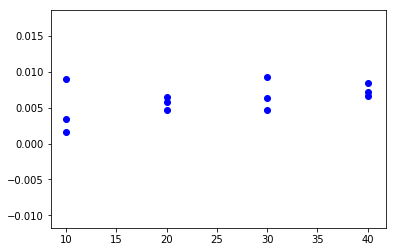

In [32]:
for i, taille in enumerate(liste_taille):
    for j in range(nb_test):
        plt.scatter(taille,list_fin[i][j], color = 'blue', )